Here we will show you how to use stable-diffusion-webui to generate image with Lora and ControlNet support. The stable-diffusion-webui will be hostd at Amazon SageMaker endpoint.

In [2]:
import sagemaker
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
# role = sagemaker.get_execution_role()
role = "arn:aws:iam::002224604296:role/service-role/AmazonSageMaker-ExecutionRole-20230319T081280"

import boto3
account_id = boto3.client('sts').get_caller_identity().get('Account')
region_name = boto3.session.Session().region_name

Prepare models directory and organize the structure as following.

In [ ]:
!mkdir -p models
!mkdir -p models/Stable-diffusion
!mkdir -p models/ControlNet
!mkdir -p models/Lora

Logout from AWS public ECR to avoid the authentication token is expired.

In [ ]:
!docker logout public.ecr.aws

Build Docker image and push to ECR.

In [ ]:
!./build_and_push.sh.lite $region_name

Install Huggingface Hub toolkit and login with your Huggingface access token.

In [ ]:
%pip install huggingface_hub
!huggingface-cli login --token [Your-huggingface-access-token]

Download Stable-diffuion models.

In [ ]:
from huggingface_hub import hf_hub_download
hf_hub_download(
    repo_id="stabilityai/stable-diffusion-2-1", 
    filename="v2-1_768-ema-pruned.ckpt", 
    local_dir="models/Stable-diffusion/"
)
hf_hub_download(
    repo_id="runwayml/stable-diffusion-v1-5", 
    filename="v1-5-pruned.ckpt", 
    local_dir="models/Stable-diffusion/"
)
!wget "https://raw.githubusercontent.com/Stability-AI/stablediffusion/main/configs/stable-diffusion/v2-inference-v.yaml" -O models/Stable-diffusion/v2-1_768-ema-pruned.yaml

Download ControlNet model.

In [ ]:
hf_hub_download(
    repo_id="lllyasviel/ControlNet", 
    filename="models/control_sd15_canny.pth", 
    local_dir="models/ControlNet/"
)
!mv models/ControlNet/models/control_sd15_canny.pth models/ControlNet/control_sd15_canny.pth
!rm -rf models/ControlNet/models

Download Lora model.

In [ ]:
!wget "https://civitai.com/api/download/models/7627" -O models/Lora/2bNierAutomataLora_v2b.safetensors

hf_hub_download(
    repo_id="andite/anything-v4.0", 
    filename="anything-v4.5-pruned.safetensors", 
    local_dir="models/Lora/"
)

Compress Stable-diffusion, ControlNet and Lora models as tar.gz archieve file when models/model.tar.gz doesn't exist.

In [ ]:
![ ! -f models/model.tar.gz ] && cd models && tar czvfh model.tar.gz Stable-diffusion ControlNet Lora

Download s5cmd which is a very fast S3 and local filesystem execution tool and place it under directory - tools/.

In [ ]:
!wget https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz -O tools/s5cmd_2.0.0_Linux-64bit.tar.gz
!tar xzvf tools/s5cmd_2.0.0_Linux-64bit.tar.gz -C tools/

Upload file - models/model.tar.gz to S3.

In [5]:
model_data = "s3://{0}/stable-diffusion-webui/data/model.tar.gz".format(bucket)
!tools/s5cmd cp models/model.tar.gz $model_data

cp models/model.tar.gz s3://sagemaker-us-west-2-002224604296/stable-diffusion-webui/data/model.tar.gz


In [3]:
model_data = "s3://{0}/stable-diffusion-webui/data/model.tar.gz".format(bucket)
model_name = None
image_uri = '{0}.dkr.ecr.{1}.amazonaws.com/ask-webui-api-gpu:latest'.format(account_id, region_name)
base_name = sagemaker.utils.base_name_from_image(image_uri)
model_environment = {
    'SAGEMAKER_MODEL_SERVER_TIMEOUT': '1200',
    'ckpt': '/opt/ml/model/v2-1_768-ema-pruned.ckpt'
}

In [4]:
from sagemaker.model import Model
from sagemaker.predictor import Predictor

In [5]:
model = Model(
    name=model_name,
    model_data=model_data,
    role=role,
    image_uri=image_uri,
    env=model_environment,
    predictor_cls=Predictor
)

In [13]:
from sagemaker.async_inference import AsyncInferenceConfig
instance_type = 'ml.g4dn.2xlarge'
instance_count = 1
async_config = AsyncInferenceConfig(output_path='s3://{0}/{1}/asyncinvoke/out/'.format(bucket, 'stable-diffusion-webui'))

Here to be simplied, we use real-time inference. However it has some limitations by nature. Real-time inference is suitable for workloads where payload sizes are up to 6MB and need to be processed with low latency requirements in the order of milliseconds or seconds Async inference is more suitable for workloads with large payload sizes and long inference processing times. Async inference also works for stable-diffusion-webui.

In [7]:
predictor = model.deploy(
    instance_type=instance_type, 
    initial_instance_count=instance_count
    #async_inference_config=async_config
)

------------------!

LoRA (Low-Rank Adaptation of Large Language Models) models have become the standard to extend the Stable Diffusion models. Let's use Lora model to generate images.

In [8]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

inputs = {
    'task': 'text-to-image', 
    'txt2img_payload': {
        'enable_hr': False, 
        'denoising_strength': 0.7, 
        'firstphase_width': 0, 
        'firstphase_height': 0, 
        'prompt': 'yorha no. 2 type b, 1girl, bangs, black blindfold, black dress, black gloves, black hairband, blindfold, blindfold removed, breasts, cleavage cutout, clothing cutout, commentary request, dress, gloves, hairband, half-closed eyes, hand up, highres, io (sinking=carousel), juliet sleeves, long sleeves, looking at viewer, medium breasts, mole, mole under mouth, nier (series), nier automata, no blindfold, parted lips, puffy sleeves, short hair, solo, thighhighs, turtleneck, upper body, white hair, bokeh <lora:2bNierAutomataLora_v2b:0.5>', 
        'styles': ['None', 'None'], 
        'seed': -1.0, 
        'subseed': -1.0, 
        'subseed_strength': 0, 
        'seed_resize_from_h': 0, 
        'seed_resize_from_w': 0, 
        'sampler_index': 'DPM++ SDE Karras', 
        'batch_size': 1, 
        'n_iter': 1, 
        'steps': 20, 
        'cfg_scale': 7, 
        'width': 512, 
        'height': 512, 
        'restore_faces': False, 
        'tiling': False, 
        'negative_prompt': '(worst quality, low quality:1.3)', 
        'eta': 1, 
        's_churn': 0, 
        's_tmax': None, 
        's_tmin': 0, 
        's_noise': 1, 
        'override_settings': {}, 
        'script_args': [0, False, False, False, "", 1, "", 0, "", True, False, False]}
}

#prediction = predictor.predict_async(inputs)
prediction = predictor.predict(inputs)

Process the generated images from real-time inference result.

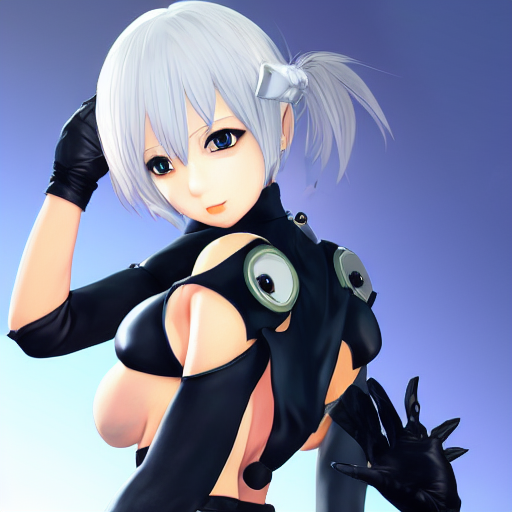

In [9]:
from PIL import Image
import io
import base64
from datetime import datetime
for image in prediction['images']:
    image = Image.open(io.BytesIO(base64.b64decode(image)))
    image.show()
    image.save(datetime.now().strftime("%Y%m%d%H%M%S.jpg"))

Resource cleanup.

In [ ]:
predictor.delete_endpoint()

# Manual MMET

In [14]:
!./build_and_push.sh.extension $region_name

set -e

# This script shows how to build the Docker image and push it to ECR to be ready for use
# by SageMaker.

# The argument to this script is the region name. 

if [ "$#" -ne 1 ] ; then
    echo "usage: $0 [region-name] [option]"
    exit 1
fi

region=$1

# Get the account number associated with the current IAM credentials
account=$(aws sts get-caller-identity --query Account --output text)

if [ $? -ne 0 ]
then
    exit 255
fi

cp Dockerfile.inference.extension Dockerfile.inference

inference_image=ask-stable-diffusion-webui-inference-api
inference_fullname=${account}.dkr.ecr.${region}.amazonaws.com/${inference_image}:latest

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${inference_image}" --region ${region} || aws ecr create-repository --repository-name "${inference_image}" --region ${region}
{
    "repositories": [
        {
            "repositoryArn": "arn:aws:ecr:us-west-2:002224604296:repository/ask-stable-diffusion-

In [16]:
!./build_and_push.sh.extension.lite $region_name

set -e

# This script shows how to build the Docker image and push it to ECR to be ready for use
# by SageMaker.

# The argument to this script is the region name. 

if [ "$#" -ne 1 ] ; then
    echo "usage: $0 [region-name] [option]"
    exit 1
fi

region=$1

# Get the account number associated with the current IAM credentials
account=$(aws sts get-caller-identity --query Account --output text)

if [ $? -ne 0 ]
then
    exit 255
fi

cp Dockerfile.inference.extension.lite Dockerfile.inference

inference_image=ask-stable-diffusion-webui-inference-api-lite
inference_fullname=${account}.dkr.ecr.${region}.amazonaws.com/${inference_image}:latest

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${inference_image}" --region ${region} || aws ecr create-repository --repository-name "${inference_image}" --region ${region}
{
    "repositories": [
        {
            "repositoryArn": "arn:aws:ecr:us-west-2:002224604296:repository/ask-stable-

In [14]:
ask_model_name = "ask-webui-extension"
ask_image_uri = '{0}.dkr.ecr.{1}.amazonaws.com/ask-webui-api-gpu:latest'.format(account_id, region_name)
ask_base_name = sagemaker.utils.base_name_from_image(ask_image_uri)
ask_model_environment = {
    'SAGEMAKER_MODEL_SERVER_TIMEOUT': '1200',
    'ckpt': '/opt/ml/model/v2-1_768-ema-pruned.ckpt'
}
ask_model = Model(
    name=None,
    model_data=model_data,
    role=role,
    image_uri=ask_image_uri,
    env=model_environment,
    predictor_cls=Predictor
)
from sagemaker.async_inference import AsyncInferenceConfig
instance_type = 'ml.g4dn.2xlarge'
instance_count = 1

ask_predictor = ask_model.deploy(
    instance_type=instance_type, 
    initial_instance_count=instance_count,
    async_inference_config=async_config
)

------------------!

In [20]:
import json
import sagemaker

sm_session = sagemaker.session.Session()
with open("input.json", "w") as outfile:
    json.dump(inputs, outfile)

In [25]:
import os

def upload_file(input_location):
    prefix = f"{bucket}/input"
    return sm_session.upload_data(
        input_location,
        bucket=sm_session.default_bucket(),
        key_prefix=prefix
    )

input_1_location = "./input.json"

input_1_s3_location = upload_file(input_1_location)
print(f"input location is {input_1_s3_location}")
prediction = ask_predictor.predict_async(input_1_s3_location)

input location is s3://sagemaker-us-west-2-002224604296/sagemaker-us-west-2-002224604296/input/input.json


Wait until the async inference is done in case we use async inferece for image generation. 

In [23]:
from sagemaker.async_inference.waiter_config import WaiterConfig
print(f"Response object: {prediction}")
print(f"Response output path: {prediction.output_path}")
print("Start Polling to get response:")

import time

start = time.time()

config = WaiterConfig(
  max_attempts=100, #  number of attempts
  delay=10 #  time in seconds to wait between attempts
  )

prediction.get_result(config)

print(f"Time taken: {time.time() - start}s")

Response object: <sagemaker.async_inference.async_inference_response.AsyncInferenceResponse object at 0x7fdc409217c0>
Response output path: s3://sagemaker-us-west-2-002224604296/stable-diffusion-webui/asyncinvoke/out/099b1a7e-a1ee-4328-907b-674b8bccdb8e.out
Start Polling to get response:


KeyboardInterrupt: 

Helper function for S3.

In [ ]:
import json
import io
from PIL import Image
s3_resource = boto3.resource('s3')

def get_bucket_and_key(s3uri):
    pos = s3uri.find('/', 5)
    bucket = s3uri[5 : pos]
    key = s3uri[pos + 1 : ]
    return bucket, key

Process the generated images from async inference result.

In [ ]:
import traceback
from PIL import Image
import base64
try:
    bucket, key = get_bucket_and_key(prediction.output_path)
    obj = s3_resource.Object(bucket, key)
    body = obj.get()['Body'].read().decode('utf-8') 
    for image in json.loads(body)['images']:
        image = Image.open(io.BytesIO(base64.b64decode(image)))
        image.show()
except Exception as e:
    traceback.print_exc()
    print(e)

Create auto scaling group for SageMaker endpoint in case you want to scale it based on particul metrics automatically.

In [ ]:
def create_autoscaling_group_for_sagemaker_endpoint(endpoint_name, min_capcity = 1, max_capcity = 2, target_value = 5):
    # application-autoscaling client
    asg_client = boto3.client("application-autoscaling")

    # This is the format in which application autoscaling references the endpoint
    resource_id = f"endpoint/{endpoint_name}/variant/AllTraffic"

    # Configure Autoscaling on asynchronous endpoint down to zero instances
    response = asg_client.register_scalable_target(
        ServiceNamespace="sagemaker",
        ResourceId=resource_id,
        ScalableDimension="sagemaker:variant:DesiredInstanceCount",
        MinCapacity=min_capcity,
        MaxCapacity=max_capcity,
    )

    response = asg_client.put_scaling_policy(
        PolicyName=f'Request-ScalingPolicy-{endpoint_name}',
        ServiceNamespace="sagemaker",
        ResourceId=resource_id,
        ScalableDimension="sagemaker:variant:DesiredInstanceCount",
        PolicyType="TargetTrackingScaling",
        TargetTrackingScalingPolicyConfiguration={
            "TargetValue": target_value,
            "CustomizedMetricSpecification": {
                "MetricName": "ApproximateBacklogSizePerInstance",
                "Namespace": "AWS/SageMaker",
                "Dimensions": [{"Name": "EndpointName", "Value": endpoint_name}],
                "Statistic": "Average",
            },
            "ScaleInCooldown": 600, # duration until scale in begins (down to zero)
            "ScaleOutCooldown": 300 # duration between scale out attempts
        },
    )

create_autoscaling_group_for_sagemaker_endpoint(predictor.endpoint_name)